# Behavioral Cloning-Project

## Driving data set

In [1]:
%load_ext autoreload
%autoreload 2

import os
import math
import time
import random
import pandas as pd
import numpy as np
import sklearn
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, Cropping2D, Lambda, Dense, Flatten, BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.optimizers import Nadam

from src import get_driving_data, \
    steering_image_batch_generator, \
    ResizeImages,\
    adjust_brightness, \
    add_rotation, \
    rotate_image, \
    add_salt_pepper_noise, \
    compute_gamma_lut

Using TensorFlow backend.


### Load data

In [2]:
data_dir = os.path.join('/home', 'Simulation_Data')
log_csv = os.path.join(data_dir, 'driving_log.csv')

driving_df = get_driving_data(log_csv)
print(driving_df.loc[5])  # print random example to check that data is as expected

Center image    IMG/center_2018_10_20_21_50_37_206.jpg
Left image        IMG/left_2018_10_20_21_50_37_206.jpg
Right image      IMG/right_2018_10_20_21_50_37_206.jpg
Steering                                     -0.122066
Name: 5, dtype: object


### Exploring data

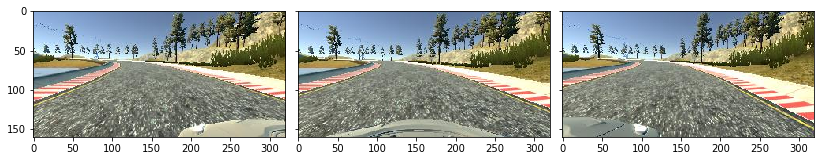

In [3]:
# Plot sample of left, center, right image
random_idx = 584
sample_center_name = driving_df.loc[random_idx]['Center image']

# Get part of file name which is same for left, center, and right:
sample_name = sample_center_name.partition('IMG/center_')[2]

sample_image = cv2.imread(os.path.join(data_dir, sample_center_name))
left_sample_image = cv2.imread(os.path.join(data_dir, f'IMG/left_{sample_name}'))
right_sample_image = cv2.imread(os.path.join(data_dir, f'IMG/right_{sample_name}'))

# Convert all sample images from BGR to RGB
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
left_sample_image = cv2.cvtColor(left_sample_image, cv2.COLOR_BGR2RGB)
right_sample_image = cv2.cvtColor(right_sample_image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
axes[0].imshow(left_sample_image)
axes[1].imshow(sample_image)
axes[2].imshow(right_sample_image)

fig.subplots_adjust(wspace=0.05)
plt.show()

In [4]:
n_samples = driving_df.shape[0]
steering_df = driving_df['Steering']
mean_steering = steering_df.mean()
min_steering = steering_df.min()
max_steering = steering_df.max()
print(f'number of steering angles recorded: {n_samples} x 3 = {n_samples*3}'
      f'\nmin steering angle: {min_steering}'
      f'\nmax steering angle: {max_steering}'
      f'\nmean steering angle: {mean_steering}')

number of steering angles recorded: 9742 x 3 = 29226
min steering angle: -1.0
max steering angle: 1.0
mean steering angle: -0.0011161202688359676


Data shows that steering angles in the driving log are already normalized to be in range between -1 and 1. For demonstration purpose I also want to look at the real angles which means that angles have to be scaled back.
The normalization code can be found here: [GitHub udacity/self-driving-car-sim](https://github.com/udacity/self-driving-car-sim/blob/bdcd588990df2db4706e772cd45d6e013631a2f2/Assets/Standard%20Assets/Vehicles/Car/Scripts/CarController.cs#L472). So, all angles are divided by the maximum steering angle before logging which equals 25° in the present version of the simulator.

In [5]:
real_angles_df = steering_df*25.0
mean_angle = real_angles_df.mean()
min_angle = real_angles_df.min()
max_angle = real_angles_df.max()
print(f'\nmin steering angle: {min_angle}'
      f'\nmax steering angle: {max_angle}'
      f'\nmean steering angle: {mean_angle}')


min steering angle: -25.0
max steering angle: 25.0
mean steering angle: -0.02790300672089913


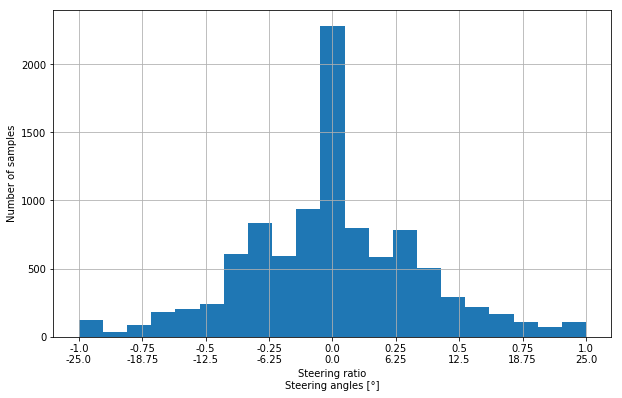

In [6]:
def plot_steering_histogram(df):
    tick_count = 9
    angles_hist = df.plot.hist(figsize=(10, 6), bins=21, grid=True)

    angles_hist.set_xlabel('Steering ratio\nSteering angles [°]')
    angles_hist.set_ylabel('Number of samples')

    angles_ticks = np.linspace(min_angle, max_angle, tick_count)
    angles_hist.set_xticks(angles_ticks)
    steering_ticks = np.linspace(min_steering, max_steering, tick_count)
    angles_hist.set_xticklabels([f'{steering_ticks[i]}\n{angles_ticks[i]}' for i in range(tick_count)])

    plt.show()

plot_steering_histogram(real_angles_df)

### Side cameras

In order to take advantage of the three cameras, I create a new data frame where the side images are not arranged as columns but are appended as new rows. Thus, threating them as independent images that have own steering angles which are calculated through an offset. This keeps batch generation simple as it just adds more samples and we do not have to deal with columns.

In [7]:
def merge_camera_images(cameras=['Center', 'Left', 'Right'],
                        camera_steering_offsets=[.0, .2, -.2],
                        verbose=0):
    camera_dataframes = [
        driving_df[[f'{cam} image', 'Steering']] \
            .rename(columns={f'{cam} image': 'Image'}) \
        for cam in cameras
    ]
    for idx, offset in enumerate(camera_steering_offsets):
        camera_dataframes[idx]['Steering'] += offset

    # Checking that the mean steering angles are in fact different by the offset:
    if verbose > 0:
        means = [df['Steering'].mean() for df in camera_dataframes]
        print(f'mean steering angles by cameras:\n{cameras}\n{str(means)}\n')
    
    # Merge all dataframes into one
    return pd.concat(camera_dataframes)

Let's have a look at the distribution of steering angles for different offsets of the left and right camera:

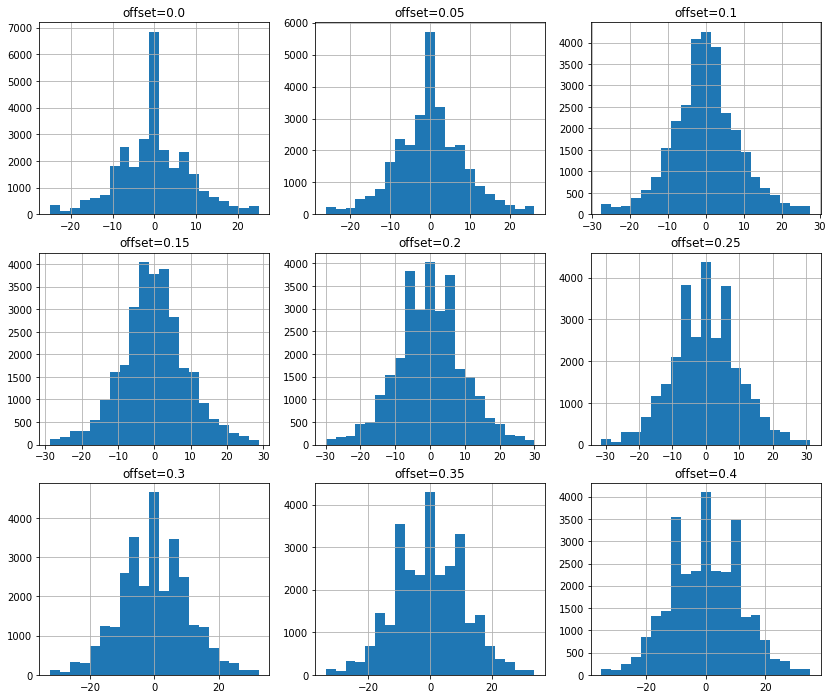

In [8]:
# Show histogram for different offsets of the camera:
offset_dfs = []
offsets = np.arange(.0, .45, .05)
for offset in offsets:
    offset_dfs.append(merge_camera_images(
        camera_steering_offsets=[0.0, offset, -offset]))
    
num_dfs = len(offset_dfs)
fig, axes = plt.subplots(math.ceil(num_dfs/3), 3, figsize=(14, 12))
idx = 0
for row in range(len(axes)):
    for col in range(len(axes[row])):
        if idx >= num_dfs:
            break
        
        cur_plot = (offset_dfs[idx]['Steering']*25).hist(ax=axes[row, col], bins=21)
        cur_plot.set_title(f'offset={offsets[idx]:.2}')
        idx += 1

Finally, I decided to use an offset of 0.25 as it performed best on both tracks particularly dealing better with sharper turns:

In [9]:
merged_df = merge_camera_images(camera_steering_offsets=[.0, .25, -.25],
                                verbose=1)
print(merged_df.shape)

mean steering angles by cameras:
['Center', 'Left', 'Right']
[-0.0011161202688359676, 0.24888387973116405, -0.25111612026883595]

(29226, 2)


### Increase data amount and normalize distribution

To double the size of the data set I am going to flip the images horizontally and invert their steering angles. The image flipping will be done in the batch generation process because we do not load the images until then. So, for now we only write every image twice into the dataframe and invert the angles:

In [10]:
tmp_df = merged_df.copy()
# New column CopyID says which number of copy it is of the original image for augmentation later.
# CopyID = 0 will be original image while CopyID = 1 will be flipped image.
tmp_df['CopyID'] = 0

copy_df = tmp_df.copy()
copy_df['CopyID'] = 1
copy_df['Steering'] *= -1

# Time to combine both data frames. 
full_df = pd.concat([tmp_df, copy_df]).reset_index(drop=True)
print(full_df.shape)

(58452, 3)


Et voila: we doubled the data set which now has zero mean in steering because through flipping we get a symmetric distribution:

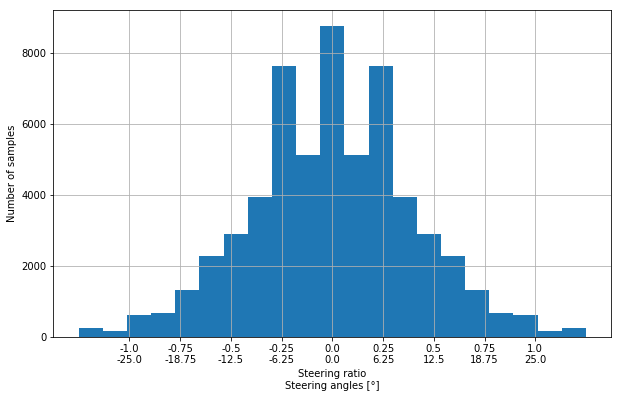

In [11]:
plot_steering_histogram(full_df['Steering']*25)

### Determine ROI

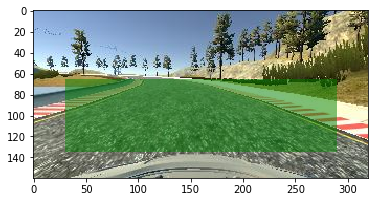

In [12]:
# Determine region of interest for cropping
original_image_height = sample_image.shape[0]
original_image_width = sample_image.shape[1]

left_crop = 30
right_crop = 30
bottom_crop = 25
top_crop = 65

left = left_crop
right = original_image_width - right_crop
bottom = original_image_height - bottom_crop
top = top_crop

rect = np.array([
    [left, top],
    [right, top],
    [right, bottom],
    [left, bottom]
])
rect_x = rect[:,0]-.5  # substract small amount to prevent plot from expanding into whitespace
rect_y = rect[:,1]

# Plot region of interest on top of sample image
plt.imshow(sample_image)
plt.fill(rect_x, rect_y, facecolor='green', alpha=.5)

### Choosing method for flipping images

This is just a small performance comparison of flipping images with either numpy or opencv to determine the better option for the batch generator:

In [13]:
def numpy_flip(img):
    return np.fliplr(img)

def cv_flip(img):
    return cv2.flip(img, 1)

In [14]:
print('numpy flip:')
%timeit -n 1000 numpy_flip(sample_image)
print('opencv flip:')
%timeit -n 1000 cv_flip(sample_image)

numpy flip:
1.64 µs ± 124 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
opencv flip:
160 µs ± 5.98 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


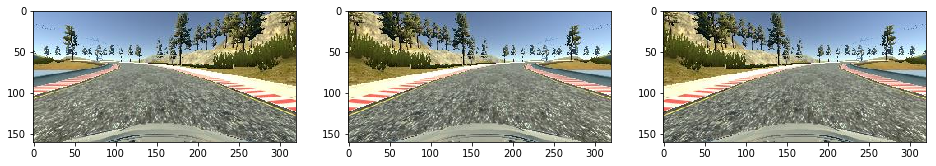

In [15]:
# Verifying function:
np_test = numpy_flip(sample_image)
cv_test = cv_flip(sample_image)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
ax1.imshow(sample_image)
ax2.imshow(np_test)
ax3.imshow(cv_test)

### More data augmentation

Next, I will explore further methods for image augmentation which are suitable for our driving data. I am going to augment the images while generating the batches which means that theoretically we can get infinite amount of data. As batch generation is one possible performance bottleneck, it is crucial that all augmentation techniques execute fast enough. So, additionally to verifying the correctness of image modifications I am also going to tune the performance through timing functions:

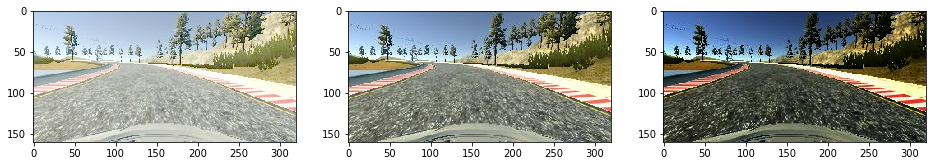

In [16]:
min_brightness = adjust_brightness(sample_image, 0.5)
max_brightness = adjust_brightness(sample_image, 2.0)

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes[0].imshow(min_brightness)
axes[1].imshow(sample_image)  # reference image
axes[2].imshow(max_brightness)

In [17]:
%timeit -n 100 adjust_brightness(sample_image, 0.5)

2.88 ms ± 57.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
gammas = np.linspace(0.5, 2.0, 20)
precomputed_gammas = [compute_gamma_lut(gamma) for gamma in gammas]
rand_gamma = random.randint(0, len(precomputed_gammas)-1)

In [19]:
%timeit -n 100 adjust_brightness(sample_image, precomputed_lut=precomputed_gammas[rand_gamma])

95.8 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


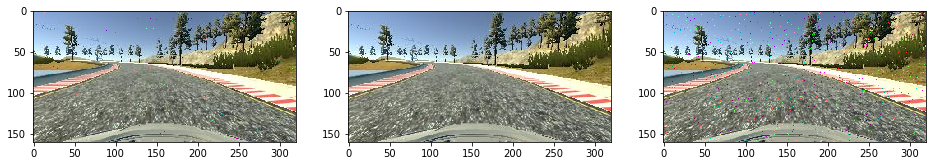

In [20]:
min_noise = add_salt_pepper_noise(sample_image, 1e-3)
max_noise = add_salt_pepper_noise(sample_image, 9e-3)

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes[0].imshow(min_noise)
axes[1].imshow(sample_image)  # reference image
axes[2].imshow(max_noise)

In [21]:
%timeit -n 100 add_salt_pepper_noise(sample_image, 0.01)

148 µs ± 8.72 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


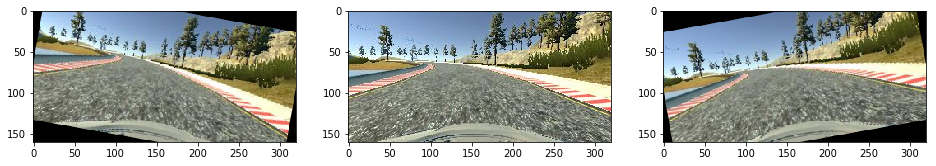

In [22]:
rotation_range = 10.0
min_rotation = rotate_image(sample_image, -rotation_range)
max_rotation = rotate_image(sample_image, rotation_range)

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes[0].imshow(min_rotation)
axes[1].imshow(sample_image)  # reference image
axes[2].imshow(max_rotation)

In [23]:
%timeit -n 100 rotate_image(sample_image, 10.0)

380 µs ± 6.71 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Create train and validation sets from driving data

In [24]:
# Create training and validation dataset
train_set, validation_set = train_test_split(full_df.values, test_size=0.2)

print(train_set[0:5])

[['IMG/center_2018_10_20_22_26_21_919.jpg' -0.5117371000000001 1]
 ['IMG/center_2018_10_20_21_51_08_042.jpg' -0.04694836 0]
 ['IMG/left_2018_10_20_22_19_30_734.jpg' -0.7053991 1]
 ['IMG/right_2018_10_20_22_32_23_025.jpg' 0.5786385000000001 1]
 ['IMG/left_2018_10_20_22_40_33_758.jpg' 0.17488262999999998 0]]


## PilotNet model

In [25]:
BATCH_SIZE = 32

In [26]:
def get_log_dir(base_path='./logs/PilotNet', path_suffix=None):
    localtime = time.localtime()
    datetime_string = time.strftime("%Y-%m-%d_%H-%M-%S", localtime)
    if path_suffix is not None:
        return f'{base_path}/{path_suffix}/{datetime_string}'
    return f'{base_path}/{datetime_string}'
    

def create_model():
    image_height = 66
    image_width = 200

    input_layer = Input(shape=(original_image_height, original_image_width, 3), name='input_image')

    # Crop the input image first, then normalize it.
    x = Cropping2D(cropping=((top_crop, bottom_crop), (left_crop, right_crop)), name='image_cropping')(input_layer)
    x = ResizeImages((image_height, image_width), name='image_resize')(x)
    x = Lambda(lambda n: n/127.5 - 1.0, name='image_normalization')(x)

    x = Conv2D(24, (5, 5), strides=(2, 2), activation='relu', name='conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(36, (5, 5), strides=(2, 2), activation='relu', name='conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(48, (5, 5), strides=(2, 2), activation='relu', name='conv3')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', name='conv4')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', name='conv5')(x)
    x = BatchNormalization()(x)
    x = Flatten(name='flatten')(x)
    x = Dense(100, activation='relu', name='dense1')(x)
    x = BatchNormalization()(x)
    x = Dense(50, activation='relu', name='dense2')(x)
    x = BatchNormalization()(x)
    x = Dense(10, activation='relu', name='dense3')(x)
    x = BatchNormalization()(x)
    x = Dense(1, activation='tanh', name='output_angle')(x)

    model = Model(inputs=input_layer, outputs=x)
    opt = Nadam(lr=.001)  # lower learning rate as training otherwise gets stuck at higher loss
    model.compile(loss='mse', optimizer=opt)
    
    return model

Summary of the architecture:

In [27]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 160, 320, 3)       0         
_________________________________________________________________
image_cropping (Cropping2D)  (None, 70, 260, 3)        0         
_________________________________________________________________
image_resize (ResizeImages)  (None, 66, 200, 3)        0         
_________________________________________________________________
image_normalization (Lambda) (None, 66, 200, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 98, 24)        96        
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 47, 36)        21636     
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


### Model testing and debugging

Training the model on a small subset of data in memory to check and debug the model architecture using TensorBoard if something shows unexpected behavior:

In [28]:
def get_batches_from_generator(generator, batch_count=5):
    x, y = [], []
    for i in range(batch_count):
        batch_x, batch_y = next(generator)
        x.extend(batch_x)
        y.extend(batch_y)
    return np.asarray(x), np.asarray(y)

# Get list of samples from generator for debugging the model with model.fit()
# model.fit() allows more options than model.fit_generator() especially for TensorBoard.
small_train_generator = steering_image_batch_generator(data_dir, train_set, augment_data=True)
small_validation_generator = steering_image_batch_generator(data_dir, validation_set)

x_train, y_train = get_batches_from_generator(small_train_generator, 10)
x_validation, y_validation = get_batches_from_generator(small_train_generator, 4)

tensorboard = TensorBoard(log_dir=get_log_dir(path_suffix='/debug'),
                          batch_size=BATCH_SIZE,
                          write_images=True,
                          write_graph=True,
                          # Gradients can't be written with BatchNormalization:
                          # write_grads=True,
                          histogram_freq=1)
checkpoint = ModelCheckpoint('PilotNet_Debug.h5', monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

debug_model = create_model()
debug_model.fit(x_train, y_train,
                validation_data=(x_validation, y_validation),
                batch_size=BATCH_SIZE,
                epochs=3,
                callbacks=[tensorboard, checkpoint, early])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


Train on 320 samples, validate on 128 samples
Epoch 1/3
320/320 [==============================] - 4s 12ms/step - loss: 0.4298 - val_loss: 0.5544

Epoch 00001: val_loss improved from inf to 0.55445, saving model to PilotNet_Debug.h5
Epoch 2/3
320/320 [==============================] - 1s 2ms/step - loss: 0.2473 - val_loss: 0.4120

Epoch 00002: val_loss improved from 0.55445 to 0.41197, saving model to PilotNet_Debug.h5
Epoch 3/3
320/320 [==============================] - 1s 2ms/step - loss: 0.1495 - val_loss: 0.3437

Epoch 00003: val_loss improved from 0.41197 to 0.34375, saving model to PilotNet_Debug.h5


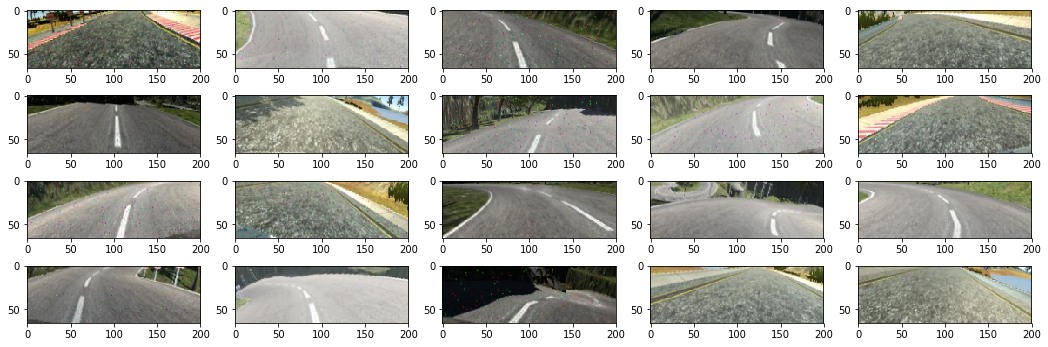

In [29]:
layer_name = 'image_resize'
intermediate_layer_model = Model(inputs=debug_model.input,
                                 outputs=debug_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_train[200:220])  # random images
fig, axes = plt.subplots(4, 5, figsize=(18, 6))
ax_list = axes.reshape(-1)
for i, ax in enumerate(ax_list):
    ax.imshow(intermediate_output[i].astype(np.uint8))

Checking that neural network has some valid predictions. If predictions are all same or very close to eachother, then there might be a mistake in our model or program.

In [30]:
test_prediction = debug_model.predict(x_train[0:10])
print(test_prediction)

[[ 0.37593892]
 [ 0.93235475]
 [ 0.01139001]
 [ 0.59013563]
 [ 0.23225729]
 [-0.01557856]
 [-0.00949865]
 [-0.76386476]
 [-0.44050545]
 [-0.3301455 ]]


### Training on final model

Training on the full dataset with image augmentation which takes longer:

In [31]:
train_generator = steering_image_batch_generator(data_dir, train_set, augment_data=True)
validation_generator = steering_image_batch_generator(data_dir, validation_set)

epoch_steps_train = len(train_set)//BATCH_SIZE
epoch_steps_validation = len(validation_set)//BATCH_SIZE

tensorboard = TensorBoard(log_dir=get_log_dir(),
                                  batch_size=BATCH_SIZE,
                                  write_graph=False)
# Save the model according to the conditions
checkpoint = ModelCheckpoint('PilotNet.h5', monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

model = create_model()
history_object = model.fit_generator(train_generator,
                                     validation_data=validation_generator,
                                     epochs=20,
                                     steps_per_epoch=epoch_steps_train,
                                     validation_steps=epoch_steps_validation,
                                     callbacks=[tensorboard, checkpoint, early])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


Epoch 1/20
1461/1461 [==============================] - 105s 72ms/step - loss: 0.0802 - val_loss: 0.0452

Epoch 00001: val_loss improved from inf to 0.04524, saving model to PilotNet.h5
Epoch 2/20
1461/1461 [==============================] - 85s 58ms/step - loss: 0.0484 - val_loss: 0.0388

Epoch 00002: val_loss improved from 0.04524 to 0.03880, saving model to PilotNet.h5
Epoch 3/20
1461/1461 [==============================] - 84s 57ms/step - loss: 0.0447 - val_loss: 0.0300

Epoch 00003: val_loss improved from 0.03880 to 0.02995, saving model to PilotNet.h5
Epoch 4/20
1461/1461 [==============================] - 83s 57ms/step - loss: 0.0412 - val_loss: 0.0291

Epoch 00004: val_loss improved from 0.02995 to 0.02909, saving model to PilotNet.h5
Epoch 5/20
1461/1461 [==============================] - 83s 57ms/step - loss: 0.0393 - val_loss: 0.0279

Epoch 00005: val_loss improved from 0.02909 to 0.02786, saving model to PilotNet.h5
Epoch 6/20
1461/1461 [==============================] - 83

Again, quickly check predictions on a few samples first. This way, I can identify gross mistakes in the training process before evaluating the network manually in the simulator (learning rate problems earlier have shown same probability on every sample):

In [32]:
prediction = model.predict(x_train[0:10])
print(prediction)

[[-0.05450462]
 [ 0.7289901 ]
 [-0.06028025]
 [ 0.32113996]
 [-0.12712003]
 [ 0.21766804]
 [-0.18301304]
 [ 0.08179078]
 [-0.17794943]
 [ 0.28605714]]


99.95339192708333
147.45897135416666
98.74977213541666
123.49395833333334
106.85536458333333
84.38452473958333


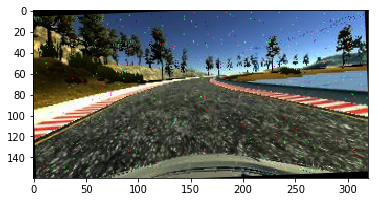

In [33]:
for i, test in enumerate(train_generator):
    if i > 5:
        break
    print(np.mean(test[0][0]))
    plt.imshow(test[0][0])

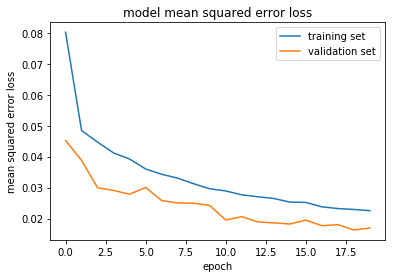

In [34]:
# Plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()